In [24]:
import numpy as np
import pandas as pd
from itertools import groupby
from operator import itemgetter

from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel as C, RBF, Matern
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from scipy.stats import norm
import scipy
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
import odor_stat_calculations as osc
from scipy.stats import kurtosis

import matplotlib.pyplot as plt 
import seaborn as sns
from figurefirst import FigureLayout,mpl_functions
from mpl_toolkits.axes_grid1 import make_axes_locatable



In [59]:
# lws= pd.read_hdf('/home/gorilla/An/data/Sprints/HighRes/NotWindy/NotWindyStatsTime_std.h5')
# df = pd.read_hdf('/home/gorilla/An/data/Sprints/LowRes/WindyForSim.h5') ## Low Res
dfres = pd.read_hdf('/home/gorilla/An/data/Sprints/HighRes/NotWindy/NotWindyMASigned.h5') ## High Res

In [64]:
index = osc.get_index(dfres.odor,4)
whiff_initiation_points = [sub[0] for sub in index]
dfres['whiff_flag'] = 0

# Set 1 for the specified indices in the 'whiff_flag' column
dfres.iloc[whiff_initiation_points, dfres.columns.get_loc('whiff_flag')] = 1

dfres['distance_along_streakline']=dfres.distance_from_source_a*dfres.xsign
dfres['nearest_from_streakline']=dfres.nearest_from_streakline*dfres.ysign

In [65]:

def avg_distance(df,index,dat): #input ; location ; storage
    i = 0
    distance_along_streakline = []
    nearest_from_streakline = []
    while i<len(index):
        distance_along_streakline.append(np.mean(df.distance_along_streakline[index[i]]))
        nearest_from_streakline.append(np.mean(df.nearest_from_streakline[index[i]]))
        i+=1
    dat['avg_distance_along_streakline']= distance_along_streakline
    dat['avg_nearest_from_streakline'] = nearest_from_streakline

def get_index_nowhiff(data, th):
    idx = [i for i, value in enumerate(data) if value < th]
    index = [list(map(itemgetter(1), g)) for k, g in groupby(enumerate(idx), lambda ix: ix[0] - ix[1])]
    return index

def avg_distance_nowhiff(df, idx, dat):
    distance_along_streakline = []
    nearest_from_streakline = []
    for indices in idx:
        if indices:  # Check if indices list is not empty
            distance_along_streakline.append(np.mean(df['distance_along_streakline'].iloc[indices]))
            nearest_from_streakline.append(np.mean(df['nearest_from_streakline'].iloc[indices]))
        else:
            distance_along_streakline.append(np.nan)
            nearest_from_streakline.append(np.nan)

    dat['avg_distance_along_streakline'] = distance_along_streakline
    dat['avg_nearest_from_streakline'] = nearest_from_streakline

def wc_wsd_nowhiff(df, idx, dat):
    wc_nowhiff = []
    std_dev_nowhiff = []
    for indices in idx:
        if indices:  # Check if indices list is not empty
            wc_nowhiff.append(np.mean(df['odor'].iloc[indices]))
            std_dev_nowhiff.append(np.std(df['odor'].iloc[indices]))
        else:
            wc_nowhiff.append(np.nan)
            std_dev_nowhiff.append(np.nan)

    dat['wc_nowhiff'] = wc_nowhiff
    dat['wsd_nowhiff'] = std_dev_nowhiff

def cal_stat(df,idx,df2):
    osc.avg_distance(df,idx,df2)
    osc.mean_conc(df,idx,df2)
    osc.whiff_blank_duration(df,idx,df2)
    osc.std_whiff(df,idx,df2)
    osc.mean_avg(df,idx,df2)
    osc.encounter_frequency(df,idx,df2,1,2)
    osc.mean_t(df,idx,df2)

th = 4
np.seterr(divide='ignore')
index = osc.get_index(dfres.odor,th)
index_nowhiff = get_index_nowhiff(dfres.odor,th)
fdf = pd.DataFrame()
fdf_nowhiff=pd.DataFrame()

cal_stat(dfres,index,fdf)
avg_distance(dfres, index, fdf)
wc_wsd_nowhiff(dfres, index_nowhiff,fdf_nowhiff)
avg_distance_nowhiff(dfres,index_nowhiff,fdf_nowhiff)

# fdf.keys()

#### Calculate LT Whiff Statistics

In [66]:
def create_class_column(dataframe):
    dataframe.loc[dataframe.avg_dist_from_source < 10, 'type'] = 0
    dataframe.loc[(dataframe.avg_dist_from_source >= 10)  & (dataframe.avg_dist_from_source < 20), 'type'] = 1
    dataframe.loc[dataframe.avg_dist_from_source >= 20, 'type'] = 2
    return dataframe

fdf_new = create_class_column(fdf)

lookback_time = 10

trainset= fdf_new

D_train=[]
mean_time_train=[]
Xtrain = []
ytrain = []
Nrows_train = []

for distance_class in [0,1,2]:
    Xtrain, ytrain, D_train, Nrows_train,mean_time_train = osc.gather_stat_timed(trainset, distance_class,
                      lookback_time, Xtrain, ytrain, D_train, Nrows_train,
                      mean_time_train)
    
def calc_val(X):
    return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])

column_names=['mc_min','mc_max','mc_mean','mc_std_dev','mc_k',
             'wf_min','wf_max','wf_mean','wf_std_dev','wf_k',
             'wd_min','wd_max','wd_mean','wd_std_dev','wd_k',
             'ma_min','ma_max','ma_mean','ma_std_dev','ma_k',
             'st_min','st_max','st_mean','st_std_dev','st_k']

traindf=pd.DataFrame(columns = column_names)
c1=[]
for i in range(len(Xtrain)):
    if(np.size(Xtrain[i])==0):
        c1.append(i)
        continue
    else:
        X=[]
        for j in range(len(Xtrain[i])):
            X.append(calc_val(Xtrain[i][j]))
        traindf.loc[i]=np.ravel(X)
        
traindf['distance']=np.delete(D_train, c1)
traindf['mean_whiff_time'] = np.delete(mean_time_train, c1)
traindf['nwhiffs'] = np.delete(Nrows_train, c1)

/tmp/ipykernel_3440706/1673441944.py:25: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])
/tmp/ipykernel_3440706/1673441944.py:25: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])
/tmp/ipykernel_3440706/1673441944.py:25: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])
/tmp/ipykernel_3440706/1673441944.py:25: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This 

(array([  28476,   28477,   28478, ..., 1068903, 1068904, 1068905]),)

(-30.0, 30.0)

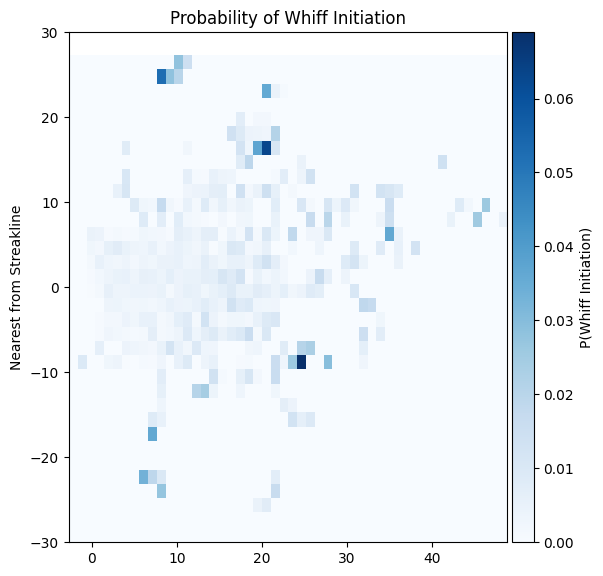

In [67]:
n_bins_x=n_bins_y=50
heatmap_whiff, xedges, yedges = np.histogram2d(dfres['distance_along_streakline'], 
                                               dfres['nearest_from_streakline'], 
                                               bins=[n_bins_x, n_bins_y], 
                                               weights=dfres['whiff_flag'])

# Histogram for total data points (irrespective of whiff initiation)
heatmap_total, _, _ = np.histogram2d(dfres['distance_along_streakline'], 
                                     dfres['nearest_from_streakline'], 
                                     bins=[n_bins_x, n_bins_y])

# Calculate the probability as number of whiff initiation points / total number of data points
with np.errstate(divide='ignore', invalid='ignore'):  # Handle division by zero
    heatmap_prob = np.divide(heatmap_whiff, heatmap_total, out=np.zeros_like(heatmap_whiff), where=heatmap_total != 0)

# Plot the original and smoothed heatmaps
f, (ax1) = plt.subplots(1, 1, figsize=(6, 8))

# Plot original heatmap (number of whiff initiation points / total data points)
cax1 = ax1.imshow(heatmap_prob.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='Blues')
divider1 = make_axes_locatable(ax1)
cbar_ax1 = divider1.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cax1, cax=cbar_ax1, label='P(Whiff Initiation)')
ax1.set_ylabel('Nearest from Streakline')
ax1.set_title('Probability of Whiff Initiation')
ax1.set_ylim(-30,30)
# ax1.set_xlim(-5,50)


Optimal Parameters:
A = 0.005468376891601862
x0 = 0.0
y0 = 0.0
sigma_x = 35.783016435639524
sigma_y = 1e-05
theta = 0.0


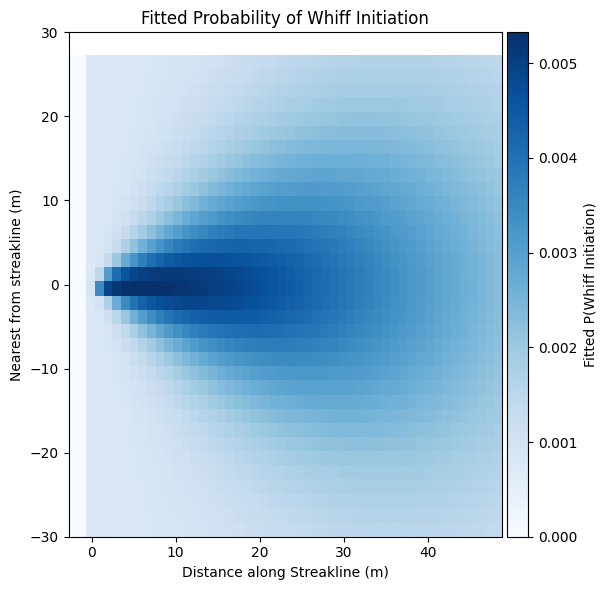

In [97]:
def directional_gaussian_plume(x, y, A, x0, y0, base_sigma_x, base_sigma_y, theta, distance_scale_factor_x,distance_scale_factor_y):
    """Calculate a directional Gaussian plume model with dynamic spread."""
    distance_from_source = np.sqrt((x - x0)**2 + (y - y0)**2)
    sigma_x = base_sigma_x + distance_scale_factor_x * distance_from_source
    sigma_y = base_sigma_y + distance_scale_factor_y * distance_from_source
    
    xp = np.cos(theta) * (x - x0) - np.sin(theta) * (y - y0)
    yp = np.sin(theta) * (x - x0) + np.cos(theta) * (y - y0)
    plume_model = A * np.exp(-((xp)**2 / (2 * sigma_x**2)) - ((yp)**2 / (2 * sigma_y**2)))
    plume_model[x<-0.5]=0
    return plume_model


# Prepare bin centers (same as before)
x_centers = (xedges[:-1] + xedges[1:]) / 2
y_centers = (yedges[:-1] + yedges[1:]) / 2
X_centers, Y_centers = np.meshgrid(x_centers, y_centers, indexing='ij')

# Flatten arrays
X_flat = X_centers.flatten()
Y_flat = Y_centers.flatten()
k_obs = heatmap_whiff.flatten()
n_obs = heatmap_total.flatten()

# Exclude bins with zero observations
valid_bins = n_obs > 0
X_flat = X_flat[valid_bins]
Y_flat = Y_flat[valid_bins]
k_obs = k_obs[valid_bins]
n_obs = n_obs[valid_bins]


def negative_log_likelihood(params, x, y, k, n):
    A, x0, y0, sigma_x, sigma_y, theta, distance_scale_factor_x,distance_scale_factor_y = params
    p = directional_gaussian_plume(x, y, A, x0, y0, sigma_x, sigma_y, theta, distance_scale_factor_x,distance_scale_factor_y)
    epsilon = 1e-10
    p = np.clip(p, epsilon, 1 - epsilon)
    ll = k * np.log(p) + (n - k) * np.log(1 - p)
    return -np.sum(ll)


# initial_params = [1.0, 0.0, 0.0, 50, 5, 0.0, 0.01, 0.1] # A, x0, y0, sigma_x, sigma_y, theta, dist_scale_x, dist_scale_y
initial_params = [1.0, 0.0, 0.0, 30, 3, 0.0, 0.02, 0.08] # A, x0, y0, sigma_x, sigma_y, theta, dist_scale_x, dist_scale_y

# Bounds as discussed
bounds = [
    (0, 1),    # A ≥ 0
    (0, 0), # x0 unbounded
    (0, 0), # y0 unbounded
    (1e-5, None), # sigma_x ≥ 1e-5
    (1e-5, None), # sigma_y ≥ 1e-5
    (0, np.pi),  # theta ∈ [-π, π]
    (0,0.02),
    (0,0.5)
]

# Perform the optimization
result = minimize(
    negative_log_likelihood,
    initial_params,
    args=(X_flat, Y_flat, k_obs, n_obs),
    bounds=bounds,
    method='L-BFGS-B'
)

# Extract optimal parameters
optimal_params = result.x
print("Optimal Parameters:")
print(f"A = {optimal_params[0]}")
print(f"x0 = {optimal_params[1]}")
print(f"y0 = {optimal_params[2]}")
print(f"sigma_x = {optimal_params[3]}")
print(f"sigma_y = {optimal_params[4]}")
print(f"theta = {optimal_params[5]}")

# Compute fitted probabilities50
fitted_p = directional_gaussian_plume(
    X_centers, Y_centers, *optimal_params
)
fitted_p_heatmap = fitted_p.reshape(heatmap_prob.shape)


# Plotting
f,ax=plt.subplots(1,1,figsize=(6, 6))
cax =ax.imshow(
    fitted_p_heatmap.T,
    origin='lower',
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    cmap='Blues'
)

divider = make_axes_locatable(ax)
cbar = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cax, cax=cbar, label='Fitted P(Whiff Initiation)')
ax.set_xlabel('Distance along Streakline (m)')
ax.set_ylabel('Nearest from streakline (m)')
ax.set_title('Fitted Probability of Whiff Initiation')
ax.set_ylim(-30,30)
f.tight_layout()

In [119]:
# df = pd.read_hdf('/home/gorilla/An/data/Sprints/LowRes/WindyForSim.h5') ## Low Re5s
df_test=dfres[100000:]
df_test.reset_index(inplace=True, drop=True)
dt=df_test.master_time[1]-df_test.master_time[0]
time = []
time.append(0)
for i in range(1,len(df_test)):
    time.append(time[i-1]+dt)
    
df_test['time'] = time


def predict_whiff_from_probability(x, y, hmap, xedges, yedges):
    x_bin = np.digitize(x, xedges) - 1  # -1 because digitize returns 1-based index
    y_bin = np.digitize(y, yedges) - 1

    if x_bin < 0 or x_bin >= hmap.shape[0] or y_bin < 0 or y_bin >= hmap.shape[1]:
        return False, 0  # No valid bin, so no whiff predicted, probability is 0
    whiff_prob = hmap[x_bin, y_bin]
    whiff_predicted = np.random.rand() < whiff_prob  # True if random number is less than the probability

    return whiff_predicted, whiff_prob
    

/tmp/ipykernel_3440706/1364819993.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['time'] = time


In [120]:
distance_threshold = 4
rows_per_second = 200
base_odor_level = 0.58 

odor_concentration_samples = np.full(len(df_test), base_odor_level)
whiff_prediction_samples = np.zeros(len(df_test), dtype=int)

test_locations = df_test[['distance_along_streakline', 'nearest_from_streakline']].values
whiff_locations = fdf[['avg_distance_along_streakline', 'avg_nearest_from_streakline']].values
nowhiff_locations = fdf_nowhiff[['avg_distance_along_streakline', 'avg_nearest_from_streakline']].values

distances = cdist(test_locations, whiff_locations)
distances_nowhiff = cdist(test_locations,nowhiff_locations )

whiff_means = fdf.mean_concentration.values
whiff_stds = fdf.std_whiff.values
whiff_duration = fdf.length_of_encounter.values
nowhiff_means = fdf_nowhiff.wc_nowhiff.values
nowhiff_wsd = fdf_nowhiff.wsd_nowhiff.values

In [121]:
i = 0
while i < len(df_test):
    dist_along, nearest_from = df_test.iloc[i][['distance_along_streakline', 'nearest_from_streakline']]
    whiff_predicted, whiff_prob = predict_whiff_from_probability(dist_along, nearest_from, 
                                                                 fitted_p_heatmap, xedges, yedges)

    if whiff_predicted and np.min(distances[i]) <= distance_threshold:
        nearest_whiff_idx = np.argmin(distances[i])
        mean_concentration = whiff_means[nearest_whiff_idx]
        std_dev_whiff = whiff_stds[nearest_whiff_idx]
        duration = int(whiff_duration[nearest_whiff_idx] * rows_per_second)
        rows_to_fill = min(duration, len(df_test) - i)

        generated_concentrations = np.random.normal(mean_concentration, std_dev_whiff, rows_to_fill)
        generated_concentrations = np.clip(generated_concentrations, 0.58, 10.2)
        odor_concentration_samples[i:i + rows_to_fill] = generated_concentrations
        whiff_prediction_samples[i:i + rows_to_fill] = 1
        i += rows_to_fill  # Move index by the number of filled rows
    else:
        i += 1  

def moving_average(data, window_size):
    if window_size < 1 or len(data) < window_size:
        return data  # Return data as is if the window size is too large for the data length
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(data, window, 'same')

# Step 2: Address No Whiff Regions
i = 0
while i < len(df_test):
    if odor_concentration_samples[i] == base_odor_level:
        nearest_no_whiff_idx = np.argmin(distances_nowhiff[i])
        no_whiff_mean = nowhiff_means[nearest_no_whiff_idx]
        no_whiff_std = nowhiff_wsd[nearest_no_whiff_idx]

        start = i
        while i < len(df_test) and odor_concentration_samples[i] == base_odor_level:
            i += 1
        end = i

        no_whiff_concentrations = np.random.normal(no_whiff_mean, no_whiff_std, end - start)
        no_whiff_concentrations = np.clip(no_whiff_concentrations, 0.58, 4)
        odor_concentration_samples[start:end] = no_whiff_concentrations
        # Apply moving average smoothing
        # smoothed_concentrations = moving_average(no_whiff_concentrations, window_size=10)

        # odor_concentration_samples[start:end] = smoothed_concentrations
    else:
        i += 1

df_test['predicted_odor'] = odor_concentration_samples
df_test['whiff_predicted'] = whiff_prediction_samples

/tmp/ipykernel_3440706/3174788549.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predicted_odor'] = odor_concentration_samples
/tmp/ipykernel_3440706/3174788549.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['whiff_predicted'] = whiff_prediction_samples


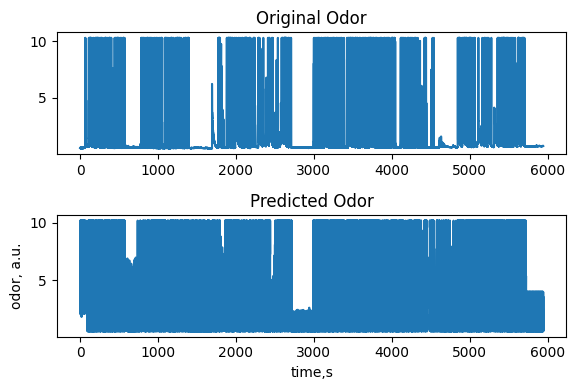

In [122]:
f,(ax1,ax2)= plt.subplots(2,1,figsize=(6,4))
ax1.plot(df_test.time, df_test.odor, label='original')
# plt.plot(df_test.smoothed_odor, label='smoothed')
ax2.plot(df_test.time, df_test.predicted_odor, label='predicted')
# ax2.axhline(4, color = 'r', linestyle = '--')

# limit=(1100,1120)
# limit = (120,130)
# ax1.set_xlim(limit)
# ax2.set_xlim(limit)
# ax2.set_ylim(0,1)

ax2.set_ylabel('odor, a.u.')
ax2.set_xlabel('time,s')
ax1.set_title('Original Odor')
ax2.set_title('Predicted Odor')
f.tight_layout()

In [123]:
th=4.5
query1 = 'odor>4.5'
new_test_df1 = df_test.query(query1)
new_test_df1.reset_index(inplace=True, drop=True)

query2 = 'predicted_odor>4.5'
new_test_df2 = df_test.query(query2)
new_test_df2.reset_index(inplace=True, drop=True)



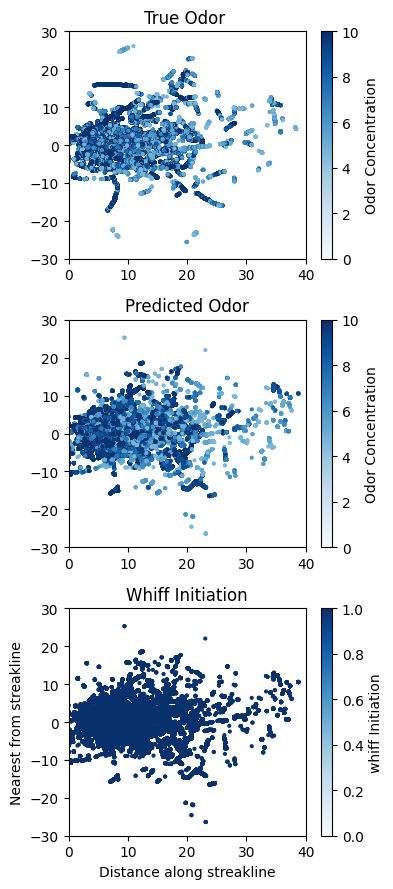

In [125]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(4, 9))
# cax1 = ax1.scatter(df_test.distance_along_streakline, df_test.nearest_from_streakline, c=df_test.odor, s = 4, cmap='Blues', vmin=0, vmax=10)
# cax2 = ax2.scatter(df_test.distance_along_streakline, df_test.nearest_from_streakline, c=df_test.predicted_odor, s = 4, cmap='Blues', vmin=0, vmax=10)
# cax3 = ax3.scatter(df_test.distance_along_streakline, df_test.nearest_from_streakline, c=df_test.whiff_predicted, s = 4, cmap='Blues', vmin=0, vmax=1)

cax1 = ax1.scatter(new_test_df1.distance_along_streakline, new_test_df1.nearest_from_streakline, c=new_test_df1.odor, s = 4, cmap='Blues', vmin=0, vmax=10)
cax2 = ax2.scatter(new_test_df2.distance_along_streakline, new_test_df2.nearest_from_streakline, c=new_test_df2.predicted_odor, s = 4, cmap='Blues', vmin=0, vmax=10)
cax3 = ax3.scatter(new_test_df2.distance_along_streakline, new_test_df2.nearest_from_streakline, c=new_test_df2.whiff_predicted, s = 4, cmap='Blues', vmin=0, vmax=1)

ylim=(-30,30)


ax1.set_title('True Odor ')
ax2.set_title('Predicted Odor')
ax3.set_title('Whiff Initiation')
ax1.set_ylim(ylim)
ax2.set_ylim(ylim)
ax3.set_ylim(ylim)
ax1.set_xlim(0,40)
ax2.set_xlim(0,40)
ax3.set_xlim(0,40)

ax3.set_xlabel('Distance along streakline')
ax3.set_ylabel('Nearest from streakline')

plt.colorbar(cax1, label='Odor Concentration')
plt.colorbar(cax2, label='Odor Concentration')
plt.colorbar(cax3, label='whiff Initiation')


f.tight_layout()

In [126]:
new_test_df = df_test.copy()

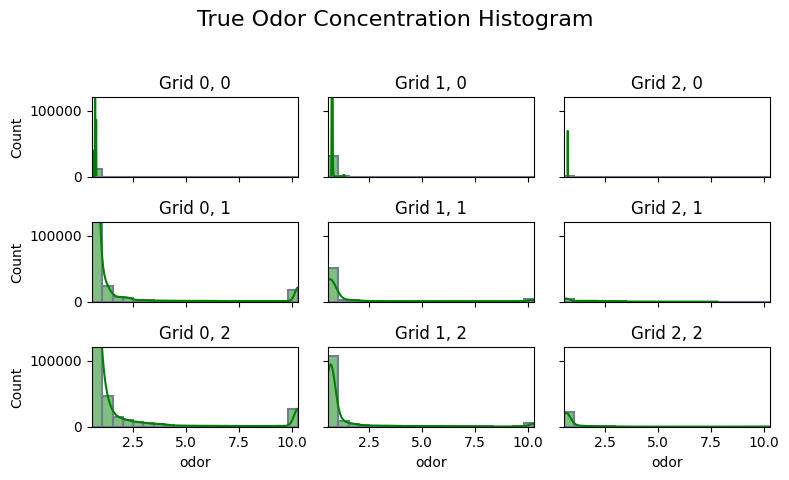

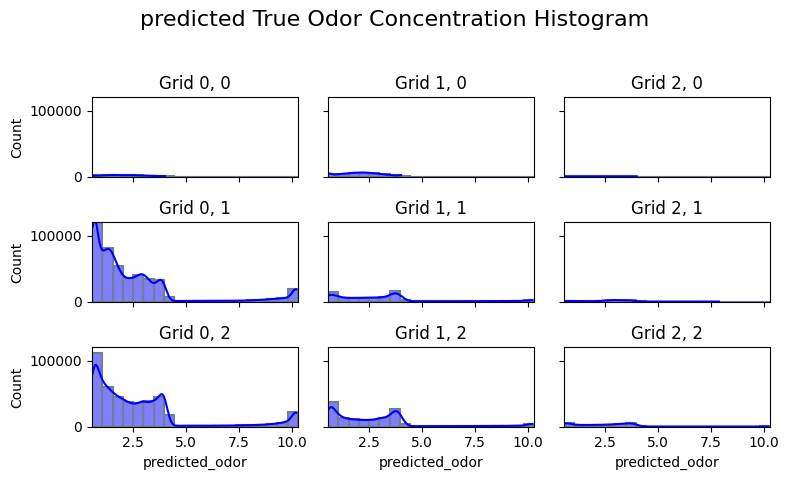

In [127]:
# new_test_df=df_test.copy()
n_bins_x = 3
n_bins_y = 3
n_bins_hist = 20

x_bin_edges = np.linspace(new_test_df['distance_along_streakline'].min(), new_test_df['distance_along_streakline'].max(), n_bins_x + 1)
y_bin_edges = np.linspace(new_test_df['nearest_from_streakline'].min(), new_test_df['nearest_from_streakline'].max(), n_bins_y + 1)

new_test_df['x_bin'] = pd.cut(new_test_df['distance_along_streakline'], bins=x_bin_edges, labels=False)
new_test_df['y_bin'] = pd.cut(new_test_df['nearest_from_streakline'], bins=y_bin_edges, labels=False)
# Determine global range for histogram bins
global_min = new_test_df[['odor', 'predicted_odor']].min().min()
global_max = new_test_df[['odor', 'predicted_odor']].max().max()
bin_edges = np.linspace(global_min, global_max, n_bins_hist + 1)

# Define specific x-axis limitsdf_test
specific_x_min = global_min
specific_x_max = global_max
ylim=[0,120000]
# Plot histograms for true odor concentration
fig, axes = plt.subplots(n_bins_y, n_bins_x, figsize=(8, 5), sharex=True, sharey=True)
for i in range(n_bins_x):
    for j in range(n_bins_y):
        grid_data = new_test_df[(new_test_df['x_bin'] == i) & (new_test_df['y_bin'] == j)]['odor']
        ax = axes[j, i]  # Note the reversed order of j and i to match the grid layout
        if not grid_data.empty:
            sns.histplot(grid_data, bins=bin_edges, kde=True, ax=ax, color='green', edgecolor='slategray', linewidth=1.5)
            ax.set_xlim([specific_x_min, specific_x_max])
            ax.set_ylim(ylim)  # Adjusted to fit the actualdf_test data range
            ax.set_title(f'Grid {i}, {j}')
        else:
            ax.set_title(f'Grid {i}, {j} (empty)')
            ax.axis('off')

fig.suptitle('True Odor Concentration Histogram', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Plot histograms for corrected true odor concentration
fig, axes = plt.subplots(n_bins_y, n_bins_x, figsize=(8, 5), sharex=True, sharey=True)
for i in range(n_bins_x):
    for j in range(n_bins_y):
        grid_data = new_test_df[(new_test_df['x_bin'] == i) & (new_test_df['y_bin'] == j)]['predicted_odor']
        ax = axes[j, i]  # Note the reversed order of j and i to match the grid layout
        if not grid_data.empty:
            sns.histplot(grid_data, bins=bin_edges, kde=True, ax=ax, color='blue', edgecolor='slategray', linewidth=1.5)
            ax.set_xlim([specific_x_min, specific_x_max])
            ax.set_ylim(ylim)  # Adjusted to fit the actual data range
            ax.set_title(f'Grid {i}, {j}')
        else:
            ax.set_title(f'Grid {i}, {j} (empty)')
            ax.axis('off')

fig.suptitle('predicted True Odor Concentration Histogram', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])


In [128]:
new_test_df=df_test.copy()

In [129]:
def cal_stat(df,idx,df2):
    osc.avg_distance(df,idx,df2)
    osc.mean_conc(df,idx,df2)
    osc.whiff_blank_duration(df,idx,df2)
    osc.std_whiff(df,idx,df2)
    osc.mean_avg(df,idx,df2)
    # osc.encounter_frequency(df,idx,df2,1,2)
    osc.mean_t(df,idx,df2)

def cal_stat_predicted(df,idx,df2):
    osc.avg_distance(df,idx,df2)
    osc.predicted_mean_conc(df,idx,df2)
    osc.whiff_blank_duration(df,idx,df2)
    osc.std_whiff_predicted(df,idx,df2)
    osc.mean_avg_predicted(df,idx,df2)
    # osc.encounter_frequency_predicted(df,idx,df2,1,2)
    osc.mean_t(df,idx,df2)
th = 4.5
np.seterr(divide='ignore')
index = osc.get_index(new_test_df.odor,th)
index_predicted = osc.get_index(new_test_df.predicted_odor,th)
fdf1 = pd.DataFrame()
fdf_predicted = pd.DataFrame()

cal_stat(new_test_df,index,fdf1)
cal_stat_predicted(new_test_df,index_predicted, fdf_predicted)

fdf1.keys()

Index(['avg_dist_from_source', 'log_avg_dist_from_source',
       'mean_concentration', 'length_of_encounter', 'odor_intermittency',
       'log_whiff', 'log_blank', 'std_whiff', 'whiff_ma', 'mean_time'],
      dtype='object')

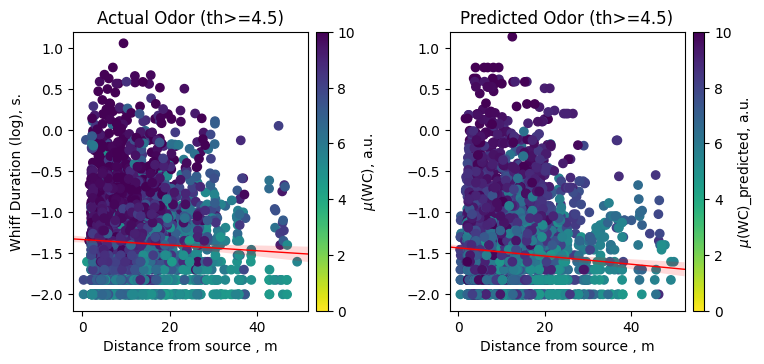

In [130]:
### WHIFF DURATION
f,(ax1,ax2)=plt.subplots(1,2,figsize=(8,4))
var = ax1.scatter(fdf1.avg_dist_from_source,fdf1.log_whiff, c=fdf1.mean_concentration, cmap='viridis_r',vmin=0,vmax=10  )
ax1.set_ylabel('$\mu$(WC), a.u.')

g1 = sns.regplot(x=fdf1.avg_dist_from_source,y=fdf1.log_whiff , data=fdf,
            ax=ax1, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(var, cax=cax, orientation = 'vertical')
cbar.solids.set(alpha=1)
cbar.set_label('$\mu$(WC), a.u.')

ax1.set_xlabel('Distance from source , m')
# ax1.set_title('Odor>0.5 =Whiff')
ax1.set_ylabel('Whiff Duration (log), s.')
ax1.set_title('Actual Odor (th>='+str(th)+')')
ax1.set_ylim(-2.2,1.2)

u=ax2.scatter(fdf_predicted.avg_dist_from_source,
              fdf_predicted.log_whiff, 
              c=fdf_predicted.mean_concentration, cmap='viridis_r',vmin=0,vmax=10)

g2 = sns.regplot(x=fdf_predicted.avg_dist_from_source,y=fdf_predicted.log_whiff , data=fdf_predicted,
            ax=ax2, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(u, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC)_predicted, a.u.')

# ax2.set_ylabel('Whiff Duration, s')
ax2.set_xlabel('Distance from source , m')
ax2.set_title('Predicted Odor (th>='+str(th)+')')
ax2.set_ylim(-2.2,1.2)

f.tight_layout(pad=2)

# mpl_functions.set_fontsize(f, 12)